# Unsupervised Learning of Disease Phenotypes from   Heterogeneous Clinical Data

Many informatics tasks such as cohort selection, trial recruitment, and clinical outcome prediction require the application of machine readable disease phenotypes to clinical data. A _phenotype_ is broadly defined as a set of observable physical and behavioral traits which arise within an organism in response to genetic and environmental influences. A _disease phenotype_ corresponds to a set of observable traits which signal the presence of a specific disease. _Expert-driven_ approaches to disease phenotyping target a single disease at a time and rely upon biomedical domain experts to manually engineer phenotype definitions from clinical variables—a resource intensive process which does not scale to large numbers of phenotypes. _Data-driven_ approaches utilize machine learning methods to infer disease phenotypes directly from clinical data. With the widespread adoption of electronic health records systems, American healthcare institutions are producing unprecedented volumes of observational clinical data. Deriving clinically meaningful information from these large-scale data demands high-throughput, data-driven methods capable of automatically inferring large numbers of disease phenotypes. Such methods promise to support a revolution in healthcare delivery in which the efficacy of clinical interventions is improved through data-driven understanding of patient health and disease.

Multi-channel Latent Dirichlet Allocation (MC-LDA) (also known as UPhenome in the informatics literature) is an unsupervised probabilistic graphical model developed specifically for inferring phenotypes directly from heterogenous, observational clinical data. MC-LDA learns phenotypes (analgous to topics in LDA) as well as patient-specific phenotype distributions (analagous to document-topic distributions in LDA). Each phenotype is composed of a set of categorical distributions where each distribution is defined over token vocabulary of a distinct data modality or _source_ (e.g. words in notes, medication names, clincal laboratory names). Each phenotypic profile corresponds to an individual patient and is itself a discrete distribution over the set of inferred phenotypes; a phenotypic profile summarizes a patient’s high-dimensional clinical data in terms of relatively low-dimensional phenotypes.

The original goal of this project was to leverage the probabilistic programming language, [Edward](http://edwardlib.org), to quickly prototype extensions to MC-LDA/UPhenome. We specifically set out to implement a time series model, the Temporal Phenome model. However, due to significant obtacles in implementing even a scalable version of LDA, led us to pivot to using Edward to simply implement MC-LDA.

In [54]:
# Library imports
%matplotlib inline
import sys
import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf

from edward.models import (
    Dirichlet, Categorical, Empirical, ParamMixture)

plt.style.use('ggplot')

# Script imports
if '../scripts' not in sys.path:
    sys.path.append('../scripts')

import data_load
import model
import inference
import plot

## Data

The data for the present study was obtained from the [Medical Information Mart for Intensive Care version III (MIMIC- III)](https://mimic.physionet.org), an openly available, deidentified clinical database covering the hospital courses of roughly 40,000 adult critical care patients admitted to Beth Israel Deaconess Medical Center in Boston, Massachusetts between 2001 and 2012. MIMIC-III contains a variety of clinical data types stored in convenient relational database tables. These data include demographics, clinical labs, medications, as well as clinical notes and reports among others.

Due to difficulties in developing a scalable Edward implemention of MC-LDA, we chose to limit ourselves to using data for patients who received treatment in the cardiac surgery recovery unit (CSRU), the majority of which underwent some type of surgical cardiac intervention. By limiting the patient pool to individuals with similar medical conditions, we hoped to train small models which would regardless produce recognizeable disease phenotypes.

Let's load our some data. We make use of the data_load script to get this done.

In [18]:
data_sources = ['note', 'lab', 'med']
w_train, dicts, D, S = data_load.load_mimic_data('../data')

print('Total number of patients: {}'.format(D))  # D = len(w_train)
print('Total number of data sources: {}'.format(S))  # S = len(dicts)
print('Data sources: {}'.format(data_sources))

Total number of patients: 10
Total number of data sources: 3
Data sources are: ['note', 'lab', 'med']


While we're at it, let's also calculate the vocabulary sizes for our data sources.

In [27]:
V = [None] * S
for s in range(S):
    V[s] = len(dicts[s])
    
print('Vocabulary sizes for data sources: {}'.format(V))

Vocabulary sizes for data sources: [84, 14, 17]


Below we print out some tokens from each vocabulary to get a sense for the data.

In [63]:
for s in range(S):
    print('Example tokens for data source: {}'.format(data_sources[s]))
    print('-----------------------------------------')
    for i, it in enumerate(dicts[s].items()):
        print(it[1])
        if i > 5: 
            break
    print()


Example tokens for data source: note
-----------------------------------------
today
radiograph
lungs
main
cath
care
well

Example tokens for data source: lab
-----------------------------------------
Calcium, Total
Phosphate
SPECIMEN TYPE
Base Excess
Calculated Total CO2
Free Calcium
Hematocrit, Calculated

Example tokens for data source: med
-----------------------------------------
Oxycodone-Acetaminophen
Atorvastatin
Morphine Sulfate
Meperidine
Nitroprusside Sodium
Phenylephrine HCl
Docusate Sodium (Liquid)



## Model

MC-LDA is a hierarchical Bayesian model with the following structure
$$
\begin{align*}
    \theta_d &\sim \text{Dir}(\alpha), \quad \alpha \in \mathbb{R}^K\\
    \phi_{s,k} &\sim \text{Dir}(\beta_s), \quad \beta_s \in \mathbb{R}^{V_s}\\
    z_{d,s,n} &\sim \text{Cat}(\theta_d)\\
    w_{d,s,n} &\sim \text{Cat}(\phi_{s, z})
\end{align*}
$$

where $d \in [1, D]$, $k \in [1, K]$, $s \in [1, S]$, and $n \in [1, N_s]$

A Gaussian process is a powerful object for modeling nonlinear
relationships between pairs of random variables. It defines a distribution over
(possibly nonlinear) functions, which can be applied for representing
our uncertainty around the true functional relationship.
Here we define a Gaussian process model for classification
(Rasumussen & Williams, 2006).

Formally, a distribution over functions $f:\mathbb{R}^D\to\mathbb{R}$ can be specified
by a Gaussian process
$$
\begin{align*}
  p(f)
  &=
  \mathcal{GP}(f\mid \mathbf{0}, k(\mathbf{x}, \mathbf{x}^\prime)),
\end{align*}
$$
whose mean function is the zero function, and whose covariance
function is some kernel which describes dependence between
any set of inputs to the function.

Given a set of input-output pairs
$\{\mathbf{x}_n\in\mathbb{R}^D,y_n\in\mathbb{R}\}$,
the likelihood can be written as a multivariate normal

\begin{align*}
  p(\mathbf{y})
  &=
  \text{Normal}(\mathbf{y} \mid \mathbf{0}, \mathbf{K})
\end{align*}

where $\mathbf{K}$ is a covariance matrix given by evaluating
$k(\mathbf{x}_n, \mathbf{x}_m)$ for each pair of inputs in the data
set.

The above applies directly for regression where $\mathbb{y}$ is a
real-valued response, but not for (binary) classification, where $\mathbb{y}$
is a label in $\{0,1\}$. To deal with classification, we interpret the
response as latent variables which is squashed into $[0,1]$. We then
draw from a Bernoulli to determine the label, with probability given
by the squashed value.

Define the likelihood of an observation $(\mathbf{x}_n, y_n)$ as

\begin{align*}
  p(y_n \mid \mathbf{z}, x_n)
  &=
  \text{Bernoulli}(y_n \mid \text{logit}^{-1}(\mathbf{x}_n^\top \mathbf{z})).
\end{align*}

Define the prior to be a multivariate normal

\begin{align*}
  p(\mathbf{z})
  &=
  \text{Normal}(\mathbf{z} \mid \mathbf{0}, \mathbf{K}),
\end{align*}

with covariance matrix given as previously stated.

Let's build the model in Edward. We use a radial basis function (RBF)
kernel, also known as the squared exponential or exponentiated
quadratic. It returns the kernel matrix evaluated over all pairs of
data points; we then Cholesky decompose the matrix to parameterize the
multivariate normal distribution.

Let's build the model in Edward. 

In [30]:
K = 5  # Number of phenotypes to model

alpha = tf.ones(K) * 0.01  # Dirichlet hyperparameters for theta

beta = [None] * S  # Dirichlet hyperparameters for phi
phi = [None] * S  # Dirchlet RV -- phenotype-token distributions
for s in range(S):
    beta[s] = tf.ones(V[s]) * 0.01
    phi[s] = Dirichlet(concentration=beta[s], 
                       sample_shape=K)

theta = [None] * D  # Dirchlet RV -- individual-phenotype distributions
z = [[None] * S for d in range(D)]  # Categorical token phenotype assignments
w = [[None] * S for d in range(D)]  # Observed tokens
for d in range(D):
    theta[d] = Dirichlet(concentration=alpha)
    
    for s in range(S):

        w[d][s] = ParamMixture(mixing_weights=theta[d], 
                               component_params={'probs': phi[s]},
                               component_dist=Categorical,
                               sample_shape=len(w_train[d][s]),
                               validate_args=True)

        z[d][s] = w[d][s].cat

## Inference

Our model has complete conjugate structure, and is thus a good candidate for inference via Gibbs sampling. Below we call a function from our inference script () pair the random variables in our model

In [31]:
T = 2000
latent_vars_dict, proposal_vars_dict, data_dict = inference.mc_lda_inference_setup(T, D, S, V, K, 
                                                                                   w_train, [theta, phi, z, w])


Building proposals for phi: 1 of 3
Total time: 6.21s,  Iteration time: 3.11s

Building proposals for phi: 2 of 3
Total time: 9.71s,  Iteration time: 3.50s

Building proposals for phi: 3 of 3
Total time: 13.28s,  Iteration time: 3.57s


Building proposals for theta, z: 1 of 10
Total time: 22.48s,  Iteration time: 9.20s

Building proposals for theta, z: 2 of 10
Total time: 34.17s,  Iteration time: 11.69s

Building proposals for theta, z: 3 of 10
Total time: 46.10s,  Iteration time: 11.92s

Building proposals for theta, z: 4 of 10
Total time: 58.41s,  Iteration time: 12.32s

Building proposals for theta, z: 5 of 10
Total time: 71.32s,  Iteration time: 12.90s

Building proposals for theta, z: 6 of 10
Total time: 83.23s,  Iteration time: 11.92s

Building proposals for theta, z: 7 of 10
Total time: 96.70s,  Iteration time: 13.47s

Building proposals for theta, z: 8 of 10
Total time: 108.81s,  Iteration time: 12.11s

Building proposals for theta, z: 9 of 10
Total time: 122.83s,  Iteration ti

In [32]:
inference = ed.Gibbs(latent_vars=latent_vars_dict,
                     proposal_vars=proposal_vars_dict,
                     data=data_dict)

inference.initialize(n_iter=T, n_print=10)

tf.global_variables_initializer().run()

for n in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    
inference.finalize()

2000/2000 [100%] ██████████████████████████████ Elapsed: 832s | Acceptance Rate: 1.000


## Criticism

In [36]:
qphi_sample = [None] * S
for s in range(S):
    qphi_s = latent_vars_dict[phi[s]]
    qphi_sample[s] = qphi_s.params[-1].eval()
    
probs = [[None] * S for k in range(K)]
for k in range(K):
    for s in range(S):
        probs[k][s] = qphi_sample[s][k, :]
        
tokens = [[None] * V[s] for s in range(S)]
for s in range(S):
    for i, token in enumerate(dicts[s].values()):
        tokens[s][i] = token

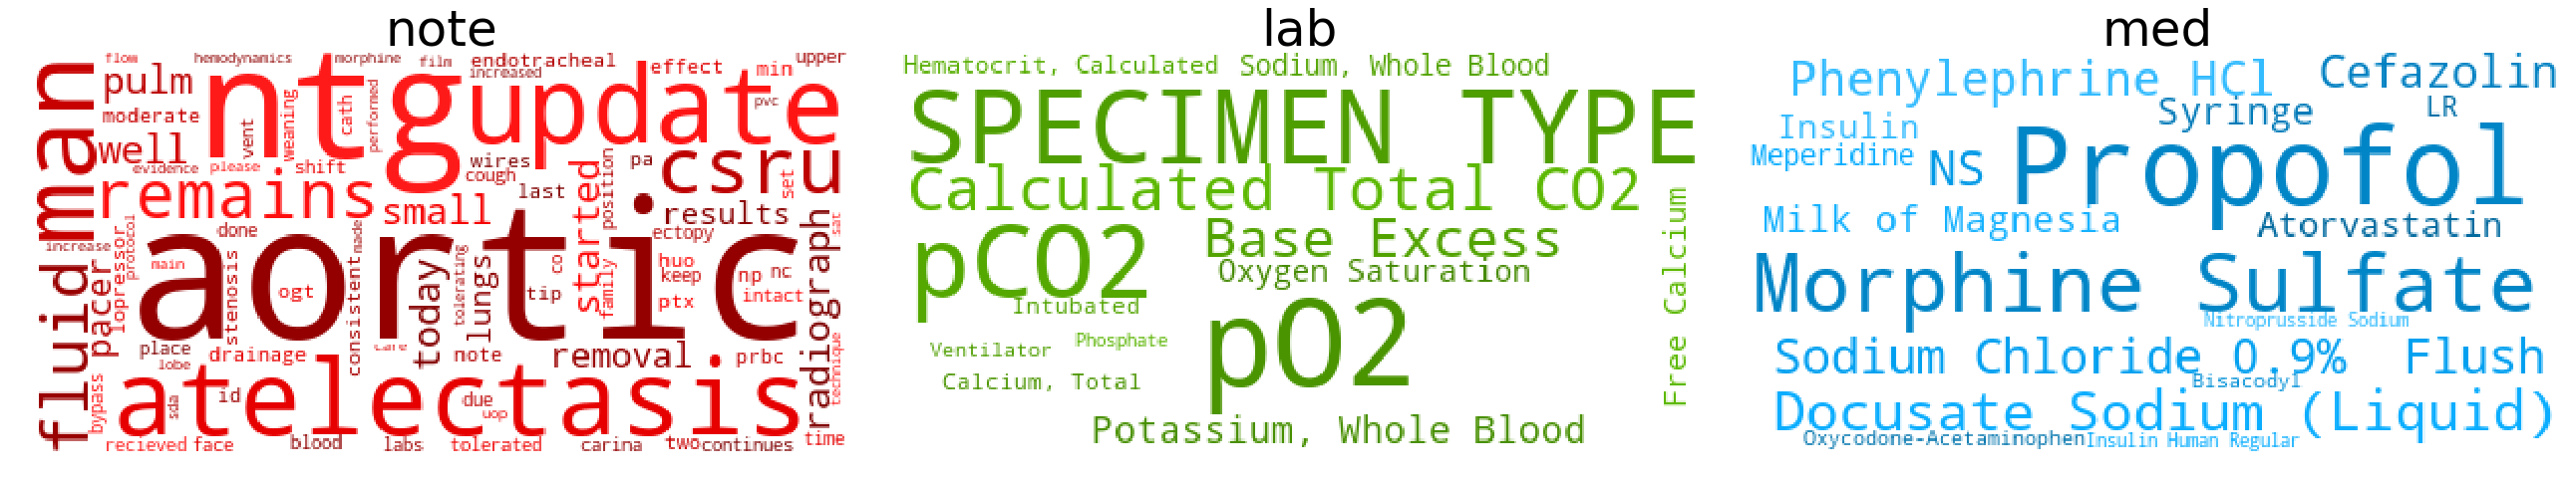

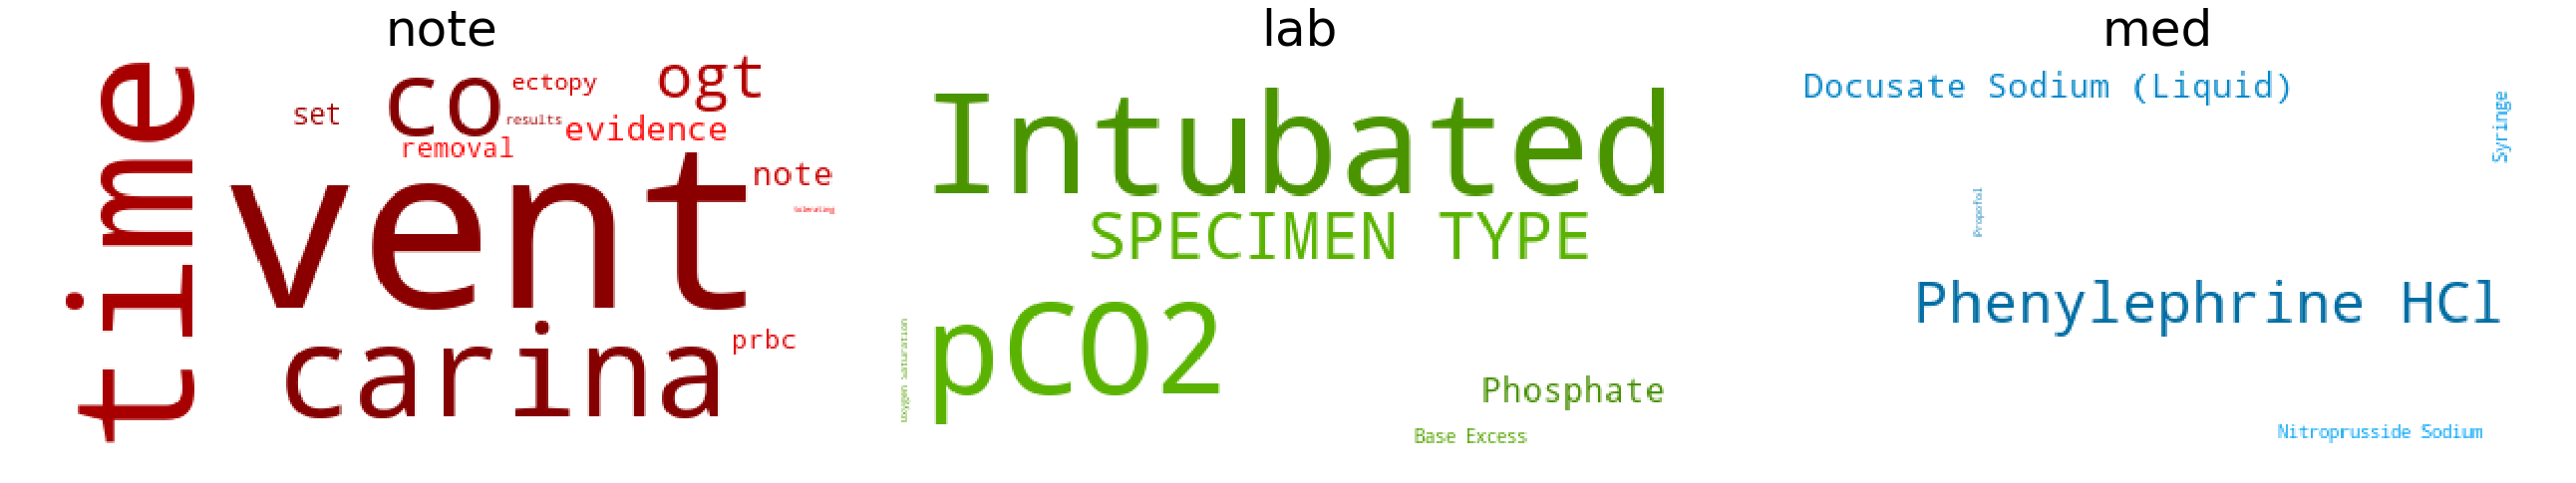

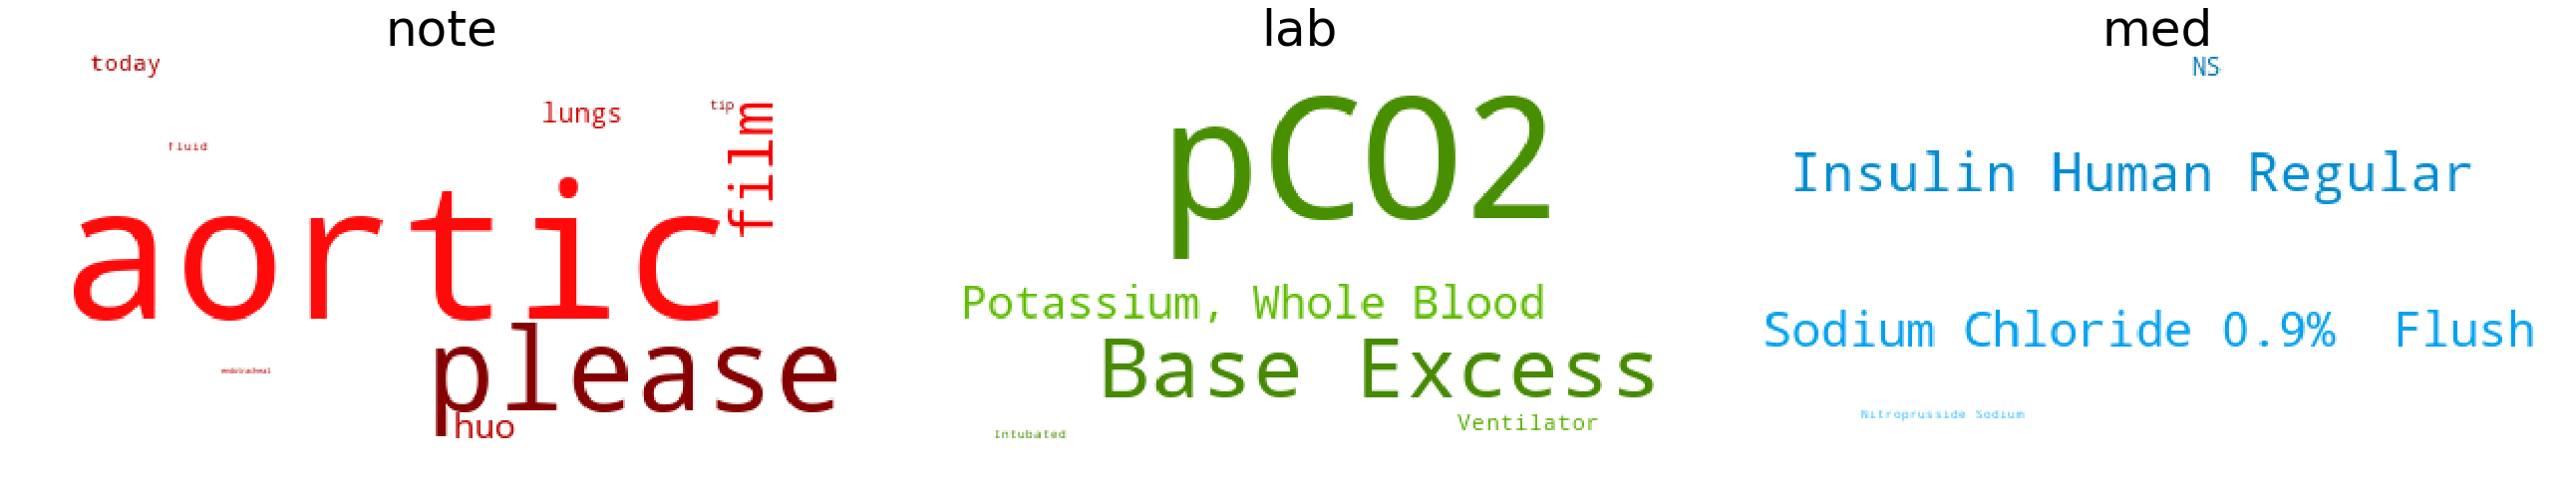

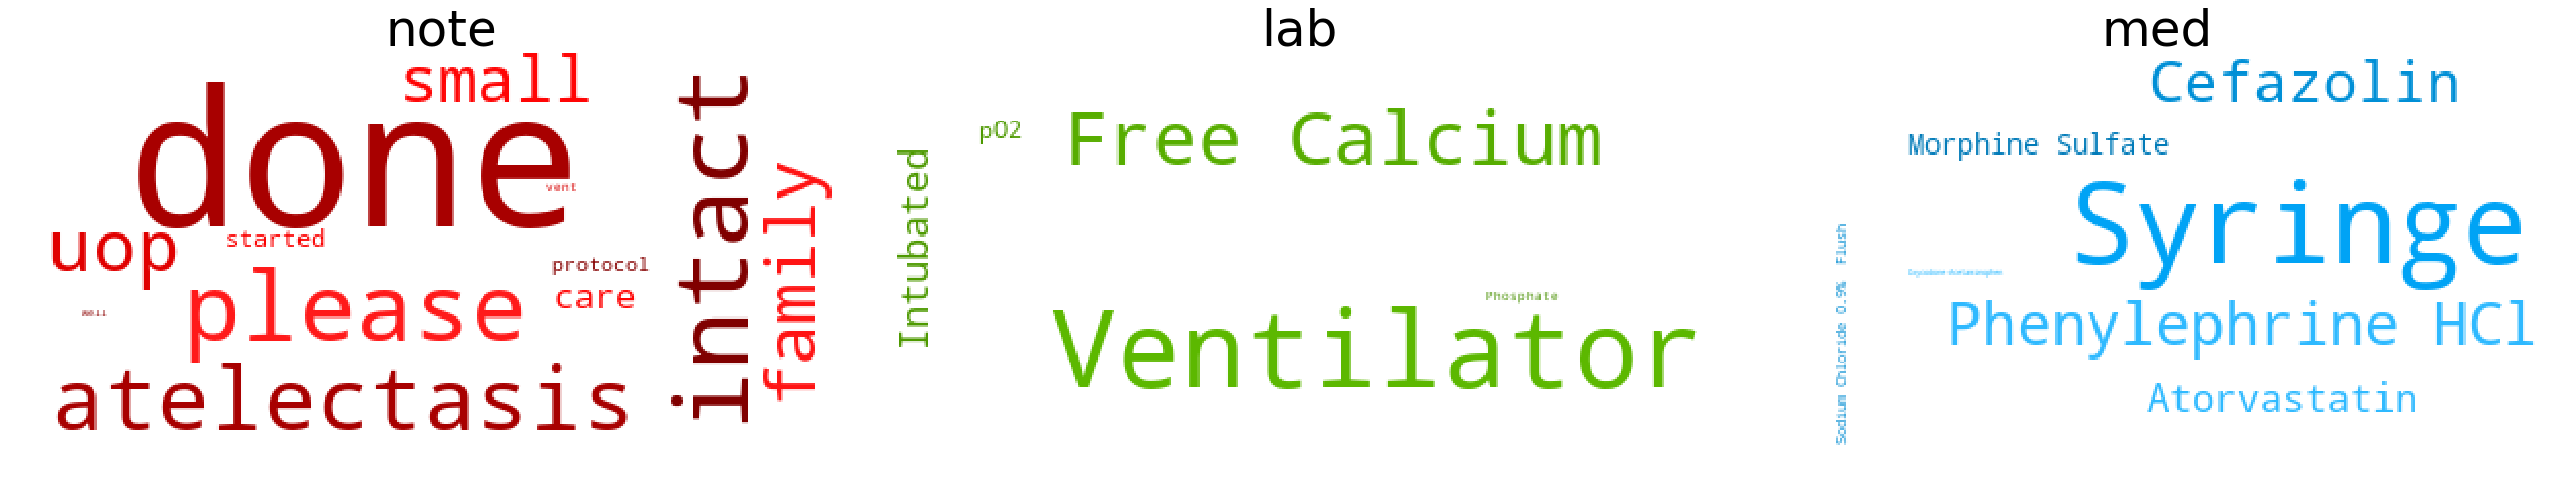

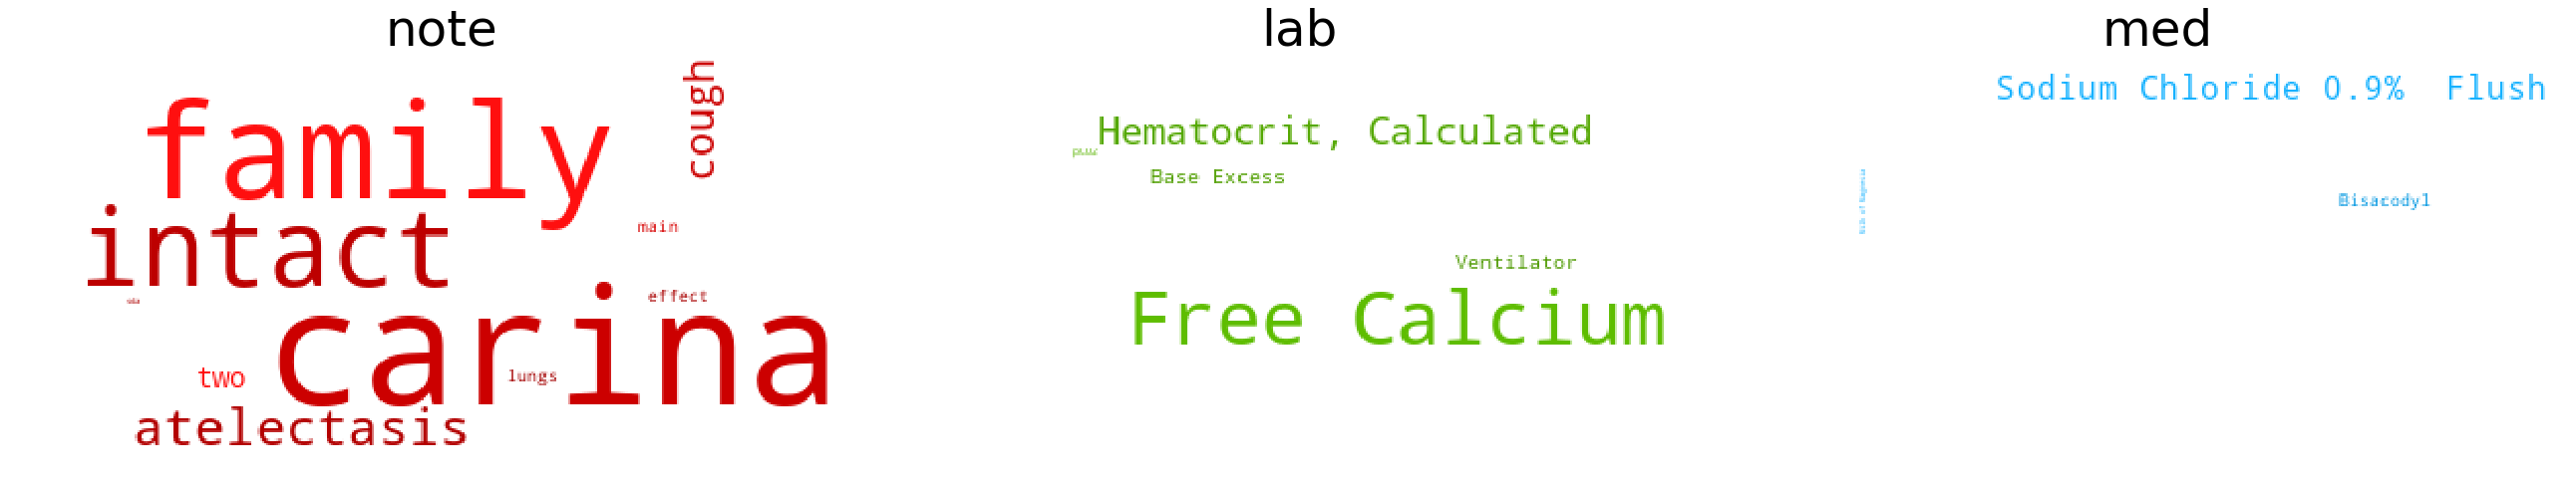

In [37]:
for k in range(K):
    plot.gen_wordcloud(tokens, probs[k])

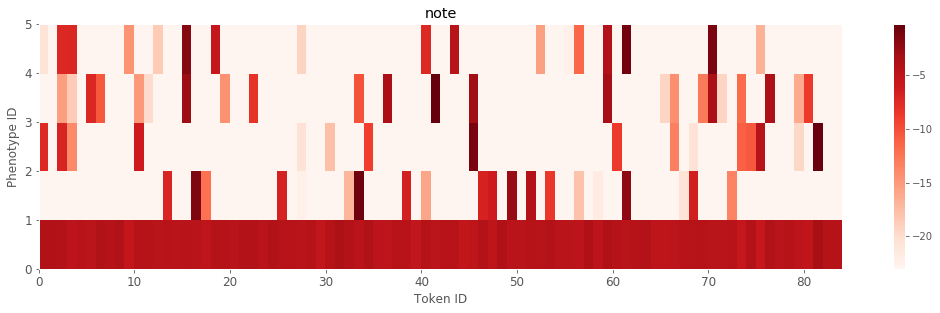

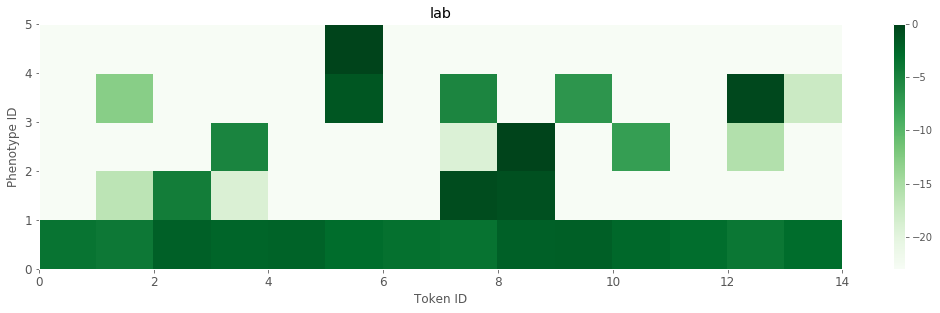

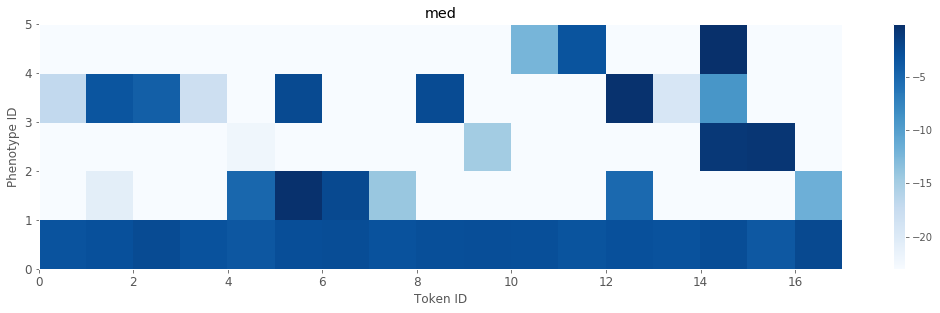

In [61]:
colormaps = ['Reds', 'Greens', 'Blues']

for s in range(S):
    plt.pcolormesh(np.log(np.clip(qphi_sample[s], a_min=1e-10, a_max=None)), cmap=colormaps[s])
    plt.tick_params(labelsize='large')
    plt.title(data_sources[s])
    plt.xlabel('Token ID')
    plt.ylabel('Phenotype ID')
    plt.colorbar()

    f = plt.gcf()
    f.set_figwidth(18.0)
    f.set_figheight(4.5)

    plt.show()